# Popularity of Netflix Movies

### Introduction:
Netflix is a streaming service that provides a wide variety of TV shows, movies, anime, documentaries and more on thousands of internet-connected devices. All movies are rated (scores, votes, popularity) using IMDb (Internet Movie Database)  and TMDB (The Movie Database). IMDb registered users can cast a vote (from 1 to 10) on every released title in the database. Individual votes are then aggregated and summarized as a single IMDb rating, visible on the title's main page. TMDB is a similar database, but instead of registered users, they receive requests to rate and rank, and approve them accordingly. Both IMDb and TMDB have ratings (scores) that is then summarized as "popularity" and "votes" for the movies and shows.
  
The question we are trying to answer is: Can we predict IMDB Score using TMDB Popularity, TMDB Score, and IMDB Votes?

For the answer to the question, we are using the dataset that contains a list of movies available on Netflix streaming and was acquired in July 2022 containing data available in the United States. The dataset includes the variables (id (the title ID on JustWatch), title (the name of the title), show_type (TV show or movie), description (a short description), release_year (year it was released), age_certification (the age certification), runtime (the length of the episode (SHOW) or movie), genres (list of genres), production_countries (countries producin the title), seasons (Number of seasons if it's a SHOW), imdb_id (the title ID on IMDb), imdb_score (score on IMDb), imdb_votes (votes on IMDb), tmdb_popularity (popularity on TMDb), tmdb_score (score on TMDb).

In [1]:
#First we load the libraries for our regression
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [5]:
#loads data from the original source on the web 
titles_data <- read_csv("https://github.com/sm020402/dsci-100-2022w1-group-98/raw/main/project_proposal/data/titles.csv")

#filter out only movies from the data and select only the columns with number values
titles_movie_data <- titles_data %>%
    filter(type == "MOVIE") %>%
    select(runtime, release_year, tmdb_popularity,imdb_score, imdb_votes, tmdb_popularity, tmdb_score)

Rows: 5850 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): id, title, type, description, age_certification, genres, production...
dbl (7): release_year, runtime, seasons, imdb_score, imdb_votes, tmdb_popula...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
#We do this step to see how many much of our data is unusable values

titles_missing_values <- sapply(titles_movie_data, function(x) sum(is.na(x))) #count missing values for every column in dataset
titles_missing_values   

runtime    release_year tmdb_popularity      imdb_score      imdb_votes 
              0               0              62             315             331 
     tmdb_score 
            195

In [14]:
# We then proceeded to remove the data associated with those values
titles_movie <- na.omit(titles_movie_data) 

In [9]:
#We set the seed once at the beginning to ensure that our analysis is reproducible
set.seed(1)

#Here we split our data into training and testing data
titles_split <- initial_split(titles_movie, prop = 0.75 , strata = tmdb_popularity)
titles_training <- training(titles_split)
titles_testing <- testing(titles_split)

In [10]:
titles_training

runtime,release_year,tmdb_popularity,imdb_score,imdb_votes,tmdb_score
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
97,1972,1.268,6.2,418,6.1
133,1979,1.370,7.2,1727,6.0
129,1969,1.265,8.1,1958,8.5
⋮,⋮,⋮,⋮,⋮,⋮
64,2021,34.522,4.7,53,7.6
25,2021,53.762,5.6,38,6.3
90,2021,26.005,3.8,68,6.3


In [12]:
titles_testing

runtime,release_year,tmdb_popularity,imdb_score,imdb_votes,tmdb_score
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
114,1976,40.965,8.2,808582,8.179
117,1966,13.123,7.3,16446,7.100
115,1954,8.915,7.5,42488,7.200
⋮,⋮,⋮,⋮,⋮,⋮
148,2021,1.978,5.1,1497,5.3
92,2021,1.971,6.8,1007,7.5
101,2021,1.748,5.0,136,6.7


In [13]:
# This step tells us how big of a difference there is in the ranges of our variables.
# That way we know whether we need to scale the data or not.

titles_mean <- titles_training %>%
    select(runtime, imdb_score, imdb_votes, tmdb_popularity, tmdb_score) %>%
    map_df(mean, na.rm = TRUE)
titles_mean

titles_max <- titles_training %>%
    select(runtime, imdb_score, imdb_votes, tmdb_popularity, tmdb_score) %>%
    map_df(max, na.rm = TRUE)

titles_min <- titles_training %>%
    select(runtime, imdb_score, imdb_votes, tmdb_popularity, tmdb_score) %>%
    map_df(min, na.rm = TRUE)

titles_range <- titles_max - titles_min
titles_range

runtime,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
101.6157,6.272379,28741.47,21.31249,6.461674


runtime,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
223,7.5,2294226,2273.444,9


#### We found the range and means of our data to get a better sense of the relative values of each category and the differences between them. The result above with the ranges and means tell us that the different categories span vastly different scales and that the data will need to be scaled and centered.

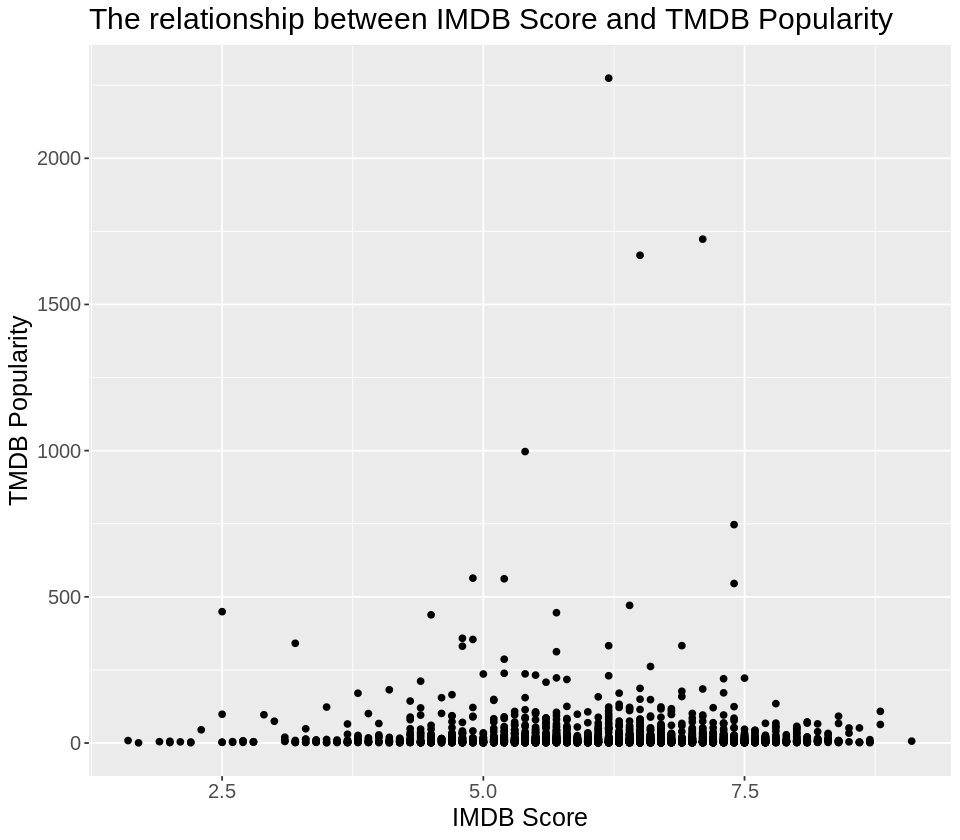

In [15]:
#Here we have visualized what our data looks like so far so that we can devise a plan for what further steps we need to take for our regression.

options(repr.plot.width = 8, repr.plot.height = 7) 
iscore_plot <- titles_training %>%
    ggplot(aes(x = imdb_score, y = tmdb_popularity)) +
    geom_point() +
    labs(x = "IMDB Score", y = "TMDB Popularity") +
    ggtitle("The relationship between IMDB Score and TMDB Popularity")+
    theme(text = element_text(size = 15))

iscore_plot

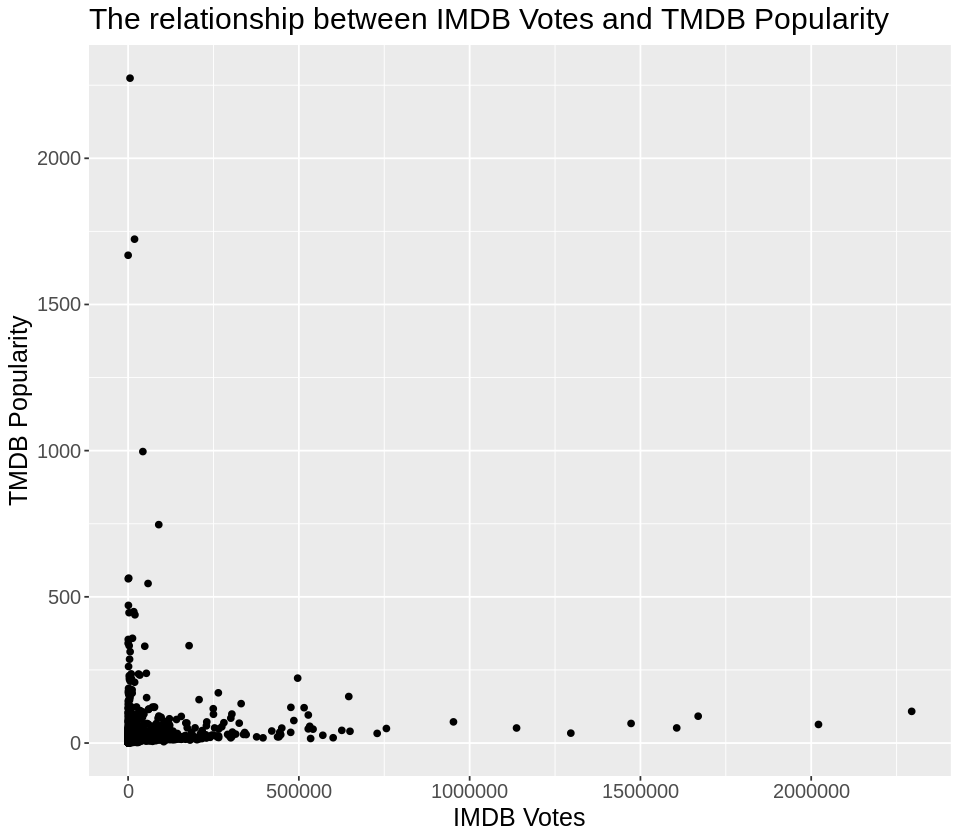

In [16]:
options(repr.plot.width = 8, repr.plot.height = 7) 
ivotes_plot <- titles_training %>%
    ggplot(aes(x = imdb_votes, y = tmdb_popularity)) +
    geom_point() +
    labs(x ="IMDB Votes", y ="TMDB Popularity") +
    ggtitle("The relationship between IMDB Votes and TMDB Popularity")+
    theme(text = element_text(size = 15))

ivotes_plot

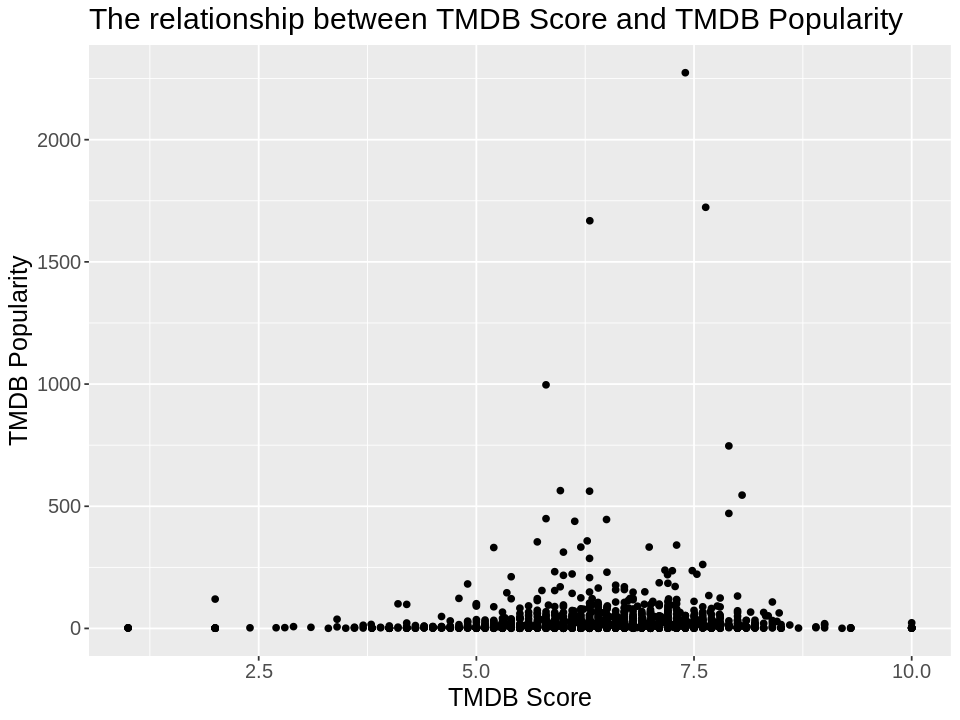

In [17]:
options(repr.plot.width = 8, repr.plot.height = 6) 
tscore_plot <- titles_training %>%
    ggplot(aes(x =  tmdb_score, y =tmdb_popularity)) +
    geom_point() +
    labs(x = "TMDB Score", y = "TMDB Popularity") +
    ggtitle("The relationship between TMDB Score and TMDB Popularity")+
    theme(text = element_text(size = 15))

tscore_plot

In [86]:
set.seed(1)
titles_vfold <- vfold_cv(titles_training, v = 5, strata = tmdb_popularity)

titles_recipe <- recipe(tmdb_popularity ~ imdb_score + imdb_votes + tmdb_score, data = titles_training) %>%
      step_scale(all_predictors()) %>%
      step_center(all_predictors())

titles_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("regression")
titles_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [87]:
set.seed(1)
titles_workflow <- workflow() %>%
    add_recipe(titles_recipe) %>%
    add_model(titles_spec)
titles_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [88]:
gridvals <- tibble(neighbors = seq(from = 1, to = 200))
titles_results <- titles_workflow %>%
    tune_grid(resamples = titles_vfold, grid = gridvals) %>%
    collect_metrics() %>%
    filter(.metric =="rmse")
titles_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,96.90140,5,13.61014,Preprocessor1_Model001
2,rmse,standard,87.17589,5,11.88690,Preprocessor1_Model002
3,rmse,standard,84.49398,5,12.18315,Preprocessor1_Model003
⋮,⋮,⋮,⋮,⋮,⋮,⋮
198,rmse,standard,74.84404,5,16.30222,Preprocessor1_Model198
199,rmse,standard,74.84406,5,16.30661,Preprocessor1_Model199
200,rmse,standard,74.84651,5,16.30570,Preprocessor1_Model200


In [89]:
titles_min <- titles_results %>%
   filter(mean == min(mean))
titles_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
93,rmse,standard,74.74419,5,16.32727,Preprocessor1_Model093


In [90]:
k_min <- titles_min %>%
    pull(neighbors)
titles_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
    set_engine("kknn") %>%
    set_mode("regression") 
titles_best_fit <- workflow() %>%
    add_recipe(titles_recipe) %>%
    add_model(titles_best_spec) %>%
    fit(data = titles_training)
titles_summary <- titles_best_fit %>%
    predict(titles_testing) %>%
    bind_cols(titles_testing) %>%
    metrics(truth = tmdb_popularity, estimate = .pred) %>%
    filter(.metric == 'rmse')
titles_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,78.07899


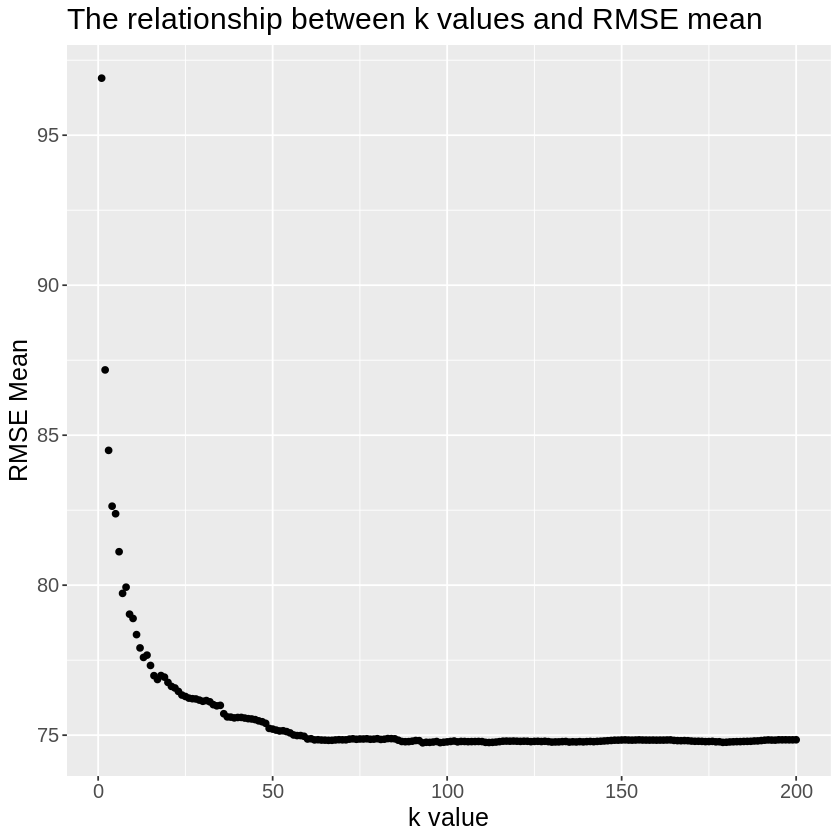

In [19]:
#visulization
titles_plot <- ggplot(titles_results, aes(x=neighbors, y=mean))+
geom_point()+
labs(x = "k value", y= "RMSE Mean")+
ggtitle("The relationship between k values and RMSE mean")+
theme(text = element_text(size = 15))
titles_plot


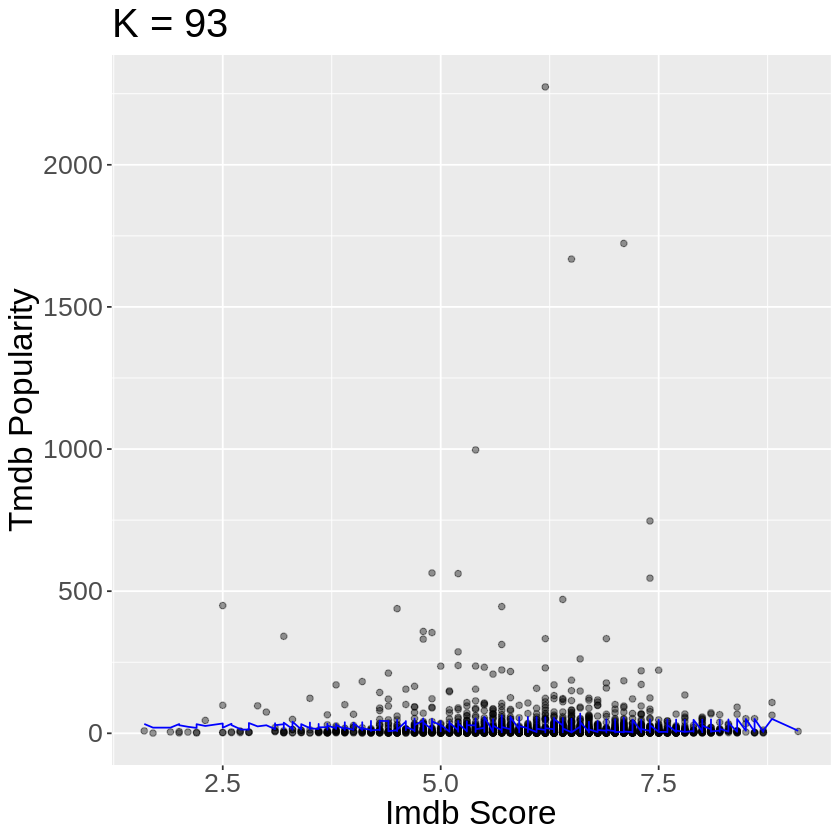

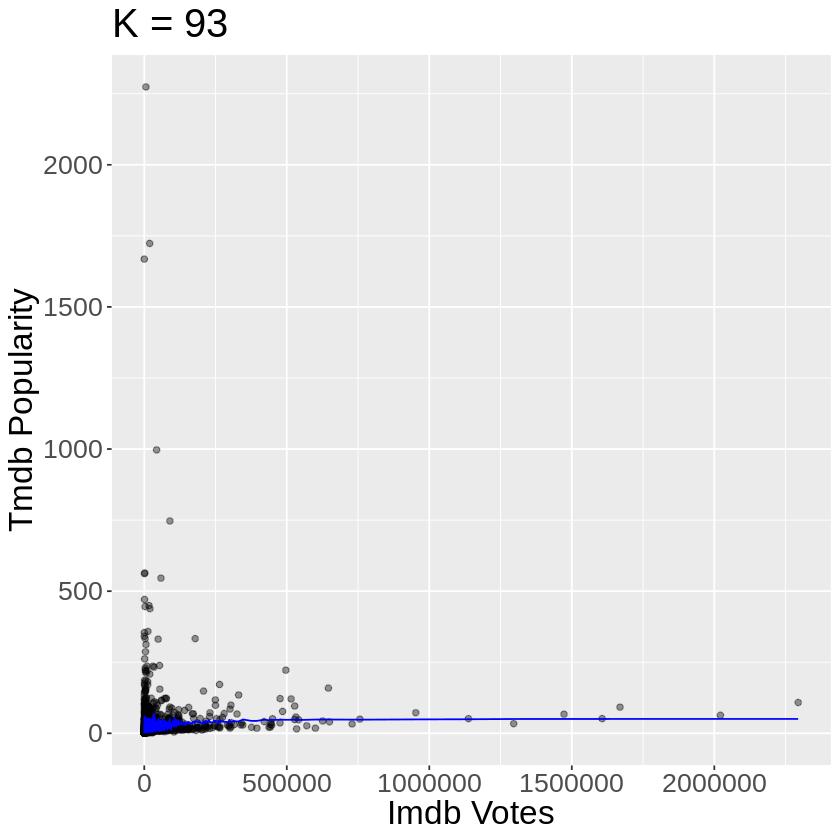

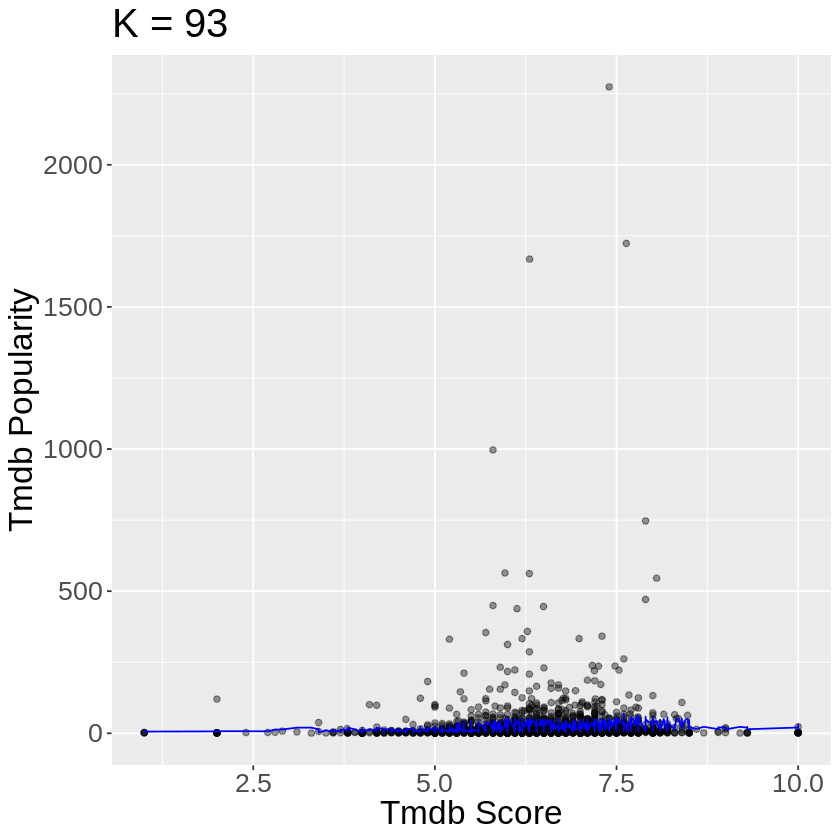

In [21]:
set.seed(1) # DO NOT CHANGE

options(repr.plot.width = 7, repr.plot.height = 7)

titles_preds <- titles_best_fit |>
                predict(titles_training) |>
                bind_cols(titles_training)

titles_plot_iscore <- ggplot(titles_preds, aes(x = imdb_score, y = tmdb_popularity)) +
            geom_point(alpha = 0.4) +
            xlab("Imdb Score") +
            ylab("Tmdb Popularity") + 
            geom_line(data = titles_preds, aes(x = imdb_score, y = .pred), color = "blue") +
            ggtitle(paste0("K = ", k_min)) +
            theme(text = element_text(size = 20))

titles_plot_ivotes <- ggplot(titles_preds, aes(x = imdb_votes, y = tmdb_popularity)) +
            geom_point(alpha = 0.4) +
            xlab("Imdb Votes") +
            ylab("Tmdb Popularity") + 
            geom_line(data = titles_preds, aes(x = imdb_votes, y = .pred), color = "blue") +
            ggtitle(paste0("K = ", k_min)) +
            theme(text = element_text(size = 20))

titles_plot_tscore <- ggplot(titles_preds, aes(x = tmdb_score, y = tmdb_popularity)) +
            geom_point(alpha = 0.4) +
            xlab("Tmdb Score") +
            ylab("Tmdb Popularity") + 
            geom_line(data = titles_preds, aes(x = tmdb_score, y = .pred), color = "blue") +
            ggtitle(paste0("K = ", k_min)) +
            theme(text = element_text(size = 20))

titles_plot_iscore
titles_plot_ivotes
titles_plot_tscore

### Methods & Results:
- describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
your report should include code which:
- loads data from the original source on the web 
- wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- performs the data analysis
- creates a visualization of the analysis 

note: all tables and figure should have a figure/table number and a legend

### Discussion:
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

### References:
- Soeiro, V. (2022). Netflix TV Shows and Movies. Kaggle.com. https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies
- Netflix | Founders, History, Shows, & Facts | Britannica. (2022). In Encyclopædia Britannica. https://www.britannica.com/topic/Netflix-Inc
- IMDb | Help. (2022). Imdb.com. https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV#
- The Movie Database. (2022). Themoviedb.org. https://www.themoviedb.org/about?language=en-CA